In [2]:
# import libraries
import os
import random
from tqdm import tqdm
from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
# get current working directory with os.getcwd()
print(os.getcwd())

os.chdir('/Users/finn/Desktop/intro_comp/Groupwork/')
print(os.getcwd())

/Users/finn/Desktop/intro_comp/Groupwork/Group1/notebooks
/Users/finn/Desktop/intro_comp/Groupwork


In [4]:
# get number of files in directory and subdirectories

# get number of files in directory and subdirectories
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

get_num_files('Group1/data/')

5220

In [218]:
def read_training_data(data_directory, split, classes, img_size):
    split_data = [[], [], []]
    classes_data = [[], [], []]

    for spl_index, spl in enumerate(split):
        spl_path = os.path.join(data_directory, spl)
        for cla_index, cla in enumerate(classes):
            path = os.path.join(data_directory, spl, cla)
            if classes.index(cla) == 0:
                class_num = np.array([[1.], [0.]])
            else:
                class_num = np.array([[0.], [1.]])
            # class_num = classes.index(cla) # !!! replaced by if else statement
            for img in os.listdir(path):
                img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                img_array = cv.resize(img_array, (img_size, img_size))
                img_array = np.reshape(img_array, (img_array.shape[0], img_array.shape[1], 1))
                img_array = img_array.astype("float32") / 255
                split_data[spl_index].append(img_array)
                classes_data[spl_index].append(class_num)
        print(spl_path, '(read', len(classes_data[spl_index]) ,'images)')

    for i in range(0, len(split_data)):
        comb_list = list(zip(split_data[i], classes_data[i]))
        random.shuffle(comb_list)
        split_data[i], classes_data[i] = zip(*comb_list)
    
    return split_data, classes_data

In [219]:
data_directory = 'Group1/data/'
split = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
img_size = 100

split_data, classes_data = read_training_data(data_directory, split, classes, img_size)

all_count_split_data = 0
for i in split_data:
    all_count_split_data += len(i)
print('All images: %s'%(all_count_split_data))

Group1/data/train (read 3756 images)
Group1/data/val (read 417 images)
Group1/data/test (read 1043 images)
All images: 5216


In [6]:
def select_random_image(split_data, classes_data, split_set):
    rand_img_num = np.random.randint(0, len(split_data[split_set]))
    img = split_data[split_set][rand_img_num]
    img_label = classes_data[split_set][rand_img_num]
    return img, img_label, rand_img_num

In [7]:
def show_random_image(classes, classes_data, img, rand_img_num, split_set=0):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(classes[np.argmax(classes_data[split_set][rand_img_num])])
    plt.show()

In [8]:
def reshape_img(img):
    return np.reshape(img, (img.shape[0], img.shape[1], 1))

In [274]:
class conv_layer: # !!! add bias to layers
    """
    Convolution layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 

    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    conv_size -> tuple of shape (h, w) -> size of convolution kernel
    kernel_num -> int -> number of kernels
    """
    def __init__(self, in_dim, conv_size=(3,3), kernel_num=4, debug = False):
        self.kernel_num = kernel_num
        self.conv_size = conv_size
        self.conv_kernels = [None] * self.kernel_num

        for i in range(0, self.kernel_num):
            if debug:
                self.conv_kernels[i] = self.debug_conv((conv_size[0], conv_size[1], in_dim[2]))
            else:
                self.conv_kernels[i] = np.random.uniform(-1,1,(conv_size[0], conv_size[1], in_dim[2]))

        self.in_dim = in_dim
        self.out_dim = (self.in_dim[0] - (conv_size[0] - 1), self.in_dim[1] - (self.conv_size[1] - 1), self.kernel_num)
    '''
    perform a forward convolution on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        self.input = img
        out_img = np.zeros(self.out_dim)
        for k in range(0, self.kernel_num):
            for h in range(0, self.out_dim[0]):
                for w in range(0, self.out_dim[1]):
                    out_img[h, w, k] = np.sum(img[h:h+self.conv_size[0], w:w+self.conv_size[1],:] * self.conv_kernels[k])
        return out_img
    
    def backward(self, grad_output, learning_rate):
        grad_input = np.zeros(self.in_dim)
        for k in range(self.kernel_num):
            for h in range(self.out_dim[0]):
                for w in range(self.out_dim[1]):
                    grad_input[h:h+self.conv_size[0], w:w+self.conv_size[1], :] += grad_output[h, w, k] * self.conv_kernels[k]
                    self.conv_kernels[k] -= learning_rate * grad_output[h, w, k] * self.input[h:h+self.conv_size[0], w:w+self.conv_size[1], :]
        return grad_input

    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim
    
    def debug_conv(self, size):
        kernel = np.zeros(size)
        for i in range(0, size[0],2):
            kernel[i,:,:] = 1
        return kernel
    
class max_pooling_layer:
    """
    Max pooling layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 
    
    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    pooling_size -> tuple of shape (h, w) -> size of pooling filter
    """    
    def __init__(self, in_dim, pooling_size=(3,3)):
        self.pooling_size = pooling_size
        self.in_dim = in_dim
        h_overflow = 1 if self.in_dim[0] % self.pooling_size[0] > 0 else 0
        w_overflow = 1 if self.in_dim[1] % self.pooling_size[1] > 0 else 0
        self.out_dim = (int(self.in_dim[0] / self.pooling_size[0]) + h_overflow, int(self.in_dim[0] / self.pooling_size[0]) + w_overflow, self.in_dim[2])
    
    '''
    perform forward pooling on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        self.input = img
        out_img = np.empty(self.out_dim)
        h_overflow = True if self.in_dim[0] / self.pooling_size[0] - self.out_dim[0] > 0 else False
        w_overflow = True if self.in_dim[1] / self.pooling_size[1] - self.out_dim[1] > 0 else False
        for d in range(0, self.out_dim[2]):
            for w in range(0, self.out_dim[0]):
                for h in range(0, self.out_dim[1]):
                    pool_size_h = self.pooling_size[0]
                    pool_size_w = self.pooling_size[1]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_h = self.in_dim[0] % self.pooling_size[0]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_w = self.in_dim[1] % self.pooling_size[1]

                    out_img[h,w,d] = np.max(img[h*pool_size_h:h*pool_size_h+pool_size_h, w*pool_size_w:w*pool_size_w+pool_size_w,d])
        return out_img

    def backward(self, grad_output, learning_rate):
        
        grad_output = np.reshape(grad_output, (self.out_dim))
        grad_input = np.zeros(self.in_dim)

        h_overflow = True if self.in_dim[0] / self.pooling_size[0] - self.out_dim[0] > 0 else False
        w_overflow = True if self.in_dim[1] / self.pooling_size[1] - self.out_dim[1] > 0 else False

        count_grad_slice = 0
        for d in range(self.out_dim[2]):
            for w in range(self.out_dim[0]):
                for h in range(self.out_dim[1]):
                    pool_size_h = self.pooling_size[0]
                    pool_size_w = self.pooling_size[1]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_h = self.in_dim[0] % self.pooling_size[0]
                    if w_overflow and w == (self.out_dim[1]-1):
                        pool_size_w = self.in_dim[1] % self.pooling_size[1]

                    grad_slice = grad_output[w, h, d]
                    count_grad_slice += 1
                    mask = (self.input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d] == np.max(self.input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d]))
                    grad_input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d] = mask * grad_slice #!!! h und w vertauscht?
                    #grad_input[h * self.pooling_size[0]:h * self.pooling_size[0] + pool_size_h, w * self.pooling_size[1]:w * self.pooling_size[1] + pool_size_w, d] += grad_output[h, w, d] * mask
        return grad_input
    
    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim
    
# currently only ReLU activation function hardcoded
class relu_activation_layer:
    '''
    ReLU activation layer performs a ReLU function on each element in the input image. 
    This means it basically set everything to zero that is smaller then zero.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    '''
    def __init__(self, in_dim,):
        self.in_dim = in_dim

    def forward(self, img):
        self.input = img
        out_img = np.stack(np.vectorize(self.relu)(img), axis=0)
        return out_img

    def backward(self, grad_output):
        grad_input = grad_output * np.vectorize(self.relu)(self.input)
        return grad_input

    def relu(self, el):
        return(np.maximum(0, el))
    
class fully_connected_layer:
    '''
    The fully connected layer transforms the input into a fully connected network
    with an output vector of out_dim.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    out_dim -> int -> defines the number of output nodes
    '''
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        w_dim = 1
        for d in in_dim:
            w_dim = w_dim * d
        self.weights = np.random.randn(self.out_dim, w_dim)
    
    
    def forward(self, img):
        self.img = img
        out_vec = np.zeros(self.out_dim)
        img_vec = img.flatten()

        for i in range(0, self.out_dim):
            out_vec[i] = np.sum(img_vec * self.weights[i])
        return out_vec
    
    def backward(self, grad_output, learning_rate):

        grad_output = np.reshape(grad_output, (np.prod(grad_output.shape), 1))
        self.img = np.reshape(self.img, (np.prod(self.img.shape), 1))
        
        grad_weights = np.dot(grad_output, self.img.T)
        grad_input = np.dot(self.weights.T, grad_output)
        self.weights -= learning_rate * grad_weights
        return grad_input
        
    def get_out_dim(self):
        return self.out_dim
    
class sigmoid_activation_layer():
    '''
    Sigmoid function and its derivative for the activation of the values of each layer
    '''
    def __init__(self):
        pass

    def sigm(self, x):
        sigm_res = 1 / (1 + np.exp(-x))
        return sigm_res
    
    def sigm_deriv(self, x):
        sigm_deriv_res = self.sigm(x) * (1 - self.sigm(x))
        return sigm_deriv_res
    
    def forward(self, img):
        self.input = img
        self.fw_res = self.sigm(self.input)
        return self.fw_res
    
    def backward(self, grad_output, learning_rate):
        self.bw_res = self.sigm_deriv(self.input)
        return self.bw_res

def bin_cross_entropy(y_true, y_pred):
    '''
    Binary cross entropy loss function describes the loss between the true and the predicted value
    '''
    bin_cross_entropy_res = -np.mean(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
    return bin_cross_entropy_res

def bin_cross_entropy_deriv(y_true, y_pred):
    '''
    Derivative of the binary cross entropy loss function
    '''
    bin_cross_entropy_deriv_res = (1/np.size(y_true))*(((1-y_true)/(1-y_pred))-(y_true/y_pred))
    return bin_cross_entropy_deriv_res

In [275]:
def pred(naive_cnn, img):
    fw = img
    for layer in naive_cnn:
        fw = layer.forward(fw)
    return fw

def train(naive_cnn, x_train, y_train, epochs, learning_rate):
    clear_output(wait=True)
    for epoch in range(0, epochs):
        loss = 0
        t_bar = tqdm(enumerate(zip(x_train, y_train)), total = len(x_train)) # !!!
        for index, (img, img_label) in t_bar:

            fw = pred(naive_cnn, img)
            fw = np.reshape(fw, (2, 1))
            loss += bin_cross_entropy(img_label, fw)
            #t_bar.set_description('Training loss: %s'%(round(loss, 4)))
            
            grad = bin_cross_entropy_deriv(img_label, fw)
            for layer in reversed(naive_cnn):
                grad = layer.backward(grad, learning_rate)
            
            #t_bar.set_description('Training loss: %s'%(round(loss_end, 4)))
            t_bar.set_description('Training loss: %s'%(round(loss, 4)))
        loss_end = loss/(index+1)
        print('Training loss: %s'%(round(loss_end, 4)))

def test(naive_cnn, x_test, y_test):
    clear_output(wait=True)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    t_bar = tqdm(enumerate(zip(x_test, y_test)), total = len(x_test)) # !!!
    #t_bar = enumerate(zip(x_test, y_test))
    for index, (img, img_label) in t_bar:
        result = pred(naive_cnn, img)
        result_idx = np.argmax(result)
        img_label_idx = np.argmax(img_label)
        if result_idx == img_label_idx:
            if img_label_idx == 1:
                tp += 1
            else:
                tn += 1
        else:
            if img_label_idx == 1:
                fn += 1
            else:
                fp += 1
        #print(f"pred: {result_idx}, true: {img_label_idx}")
    print('TP %s, TN %s, FP %s, FN %s'%(tp, tn, fp, fn))
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print('Accuracy: %s'%(round(accuracy, 4)))
    precision = tp/(tp+fp)
    print('Precision: %s'%(round(precision, 4)))
    recall = tp/(tp+fn)
    print('Recall: %s'%(round(recall, 4)))
    f1 = 2*((precision*recall)/(precision+recall))
    print('F1: %s'%(round(f1, 4)))

# def test(naive_cnn, x_test, y_test):
#     for x, y in zip(x_test, y_test):
#         output = pred(naive_cnn, x)
#         print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

### Following Cell is for full training and validation (when backpropagation is finished)

In [235]:
data_directory = 'Group1/data/'
split = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
img_size = 100

split_data, classes_data = read_training_data(data_directory, split, classes, img_size)

all_count_split_data = 0
for i in split_data:
    all_count_split_data += len(i)
print('All images: %s'%(all_count_split_data))

Group1/data/train (read 3756 images)
Group1/data/val (read 417 images)
Group1/data/test (read 1043 images)
All images: 5216


In [260]:
naive_cnn = [
    conv_layer(in_dim=reshape_img(split_data[0][0]).shape, conv_size=(3,3), kernel_num=2),
    max_pooling_layer(in_dim=(98, 98, 2), pooling_size=(3,3)),
    sigmoid_activation_layer(),
    fully_connected_layer(in_dim=(33, 33, 2), out_dim=200),
    sigmoid_activation_layer(),    
    fully_connected_layer(in_dim=(200, 1), out_dim=20),
    sigmoid_activation_layer(),    
    fully_connected_layer(in_dim=(20, 1), out_dim=2),
    sigmoid_activation_layer()
]

train(naive_cnn, split_data[0], classes_data[0], epochs=3, learning_rate=0.1)

  0%|          | 0/3756 [00:00<?, ?it/s]

Training loss: 2.2275


  0%|          | 0/3756 [00:00<?, ?it/s]

Training loss: 2.9126


  0%|          | 0/3756 [00:00<?, ?it/s]

Training loss: 3.1457


In [266]:
test(naive_cnn, split_data[2], classes_data[2])

  0%|          | 0/1043 [00:00<?, ?it/s]

TP 58, TN 258, FP 10, FN 717
Accuracy: 0.303
Precision: 0.8529
Recall: 0.0748
F1: 0.1376


### Older Version

In [ ]:
learning_rate = 0.1
c1 = conv_layer(in_dim=reshape_img(split_data[0][0]).shape, conv_size=(3,3), kernel_num=2)
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
sig_cp1 = sigmoid_activation_layer()
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=100)
sig_f1 = sigmoid_activation_layer()
f2 = fully_connected_layer(in_dim=(f1.get_out_dim(), 1), out_dim=20)
sig_f2 = sigmoid_activation_layer()
f3 = fully_connected_layer(in_dim=(f2.get_out_dim(), 1), out_dim=2)
sig_f3 = sigmoid_activation_layer()

epochs = 5 # !!!
test_purpose = 100 # !!!

#val_loss = 0

clear_output(wait=True)
for epoch in range(0, epochs):
    loss = 0
    #for train_split in [0, 1]: #0 is training, 1 is validation
    #t_bar = tqdm(enumerate(zip(split_data[0][:test_purpose], classes_data[0][:test_purpose])), total = len(split_data[0][:test_purpose])) # !!!
    t_bar = tqdm(enumerate(zip(split_data[0], classes_data[0])), total = len(split_data[0])) # !!!
    for index, (img, img_label) in t_bar:
        fw = c1.forward(img)
        fw = p1.forward(fw)
        fw = sig_cp1.forward(fw)
        fw = f1.forward(fw)
        fw = sig_f1.forward(fw)
        fw = f2.forward(fw)
        fw = sig_f2.forward(fw)
        fw = f3.forward(fw)
        fw = sig_f3.forward(fw)

        # if train_split == 0:
        
        loss += bin_cross_entropy(img_label, fw)
        t_bar.set_description('Training loss: %s'%(round(loss, 2)))
        #print('Training loss:', loss)
        
        # else:
            # val_loss += bin_cross_entropy(img_label, fw)
            # t_bar.set_description('Validation loss: %s'%(round(val_loss, 2)))
            #print('Validation loss:',loss)

        grad = bin_cross_entropy_deriv(img_label, fw)

        grad = sig_f3.backward(grad, learning_rate)
        grad = f3.backward(grad, learning_rate)
        grad = sig_f2.backward(grad, learning_rate)
        grad = f2.backward(grad, learning_rate)
        grad = sig_f1.backward(grad, learning_rate)
        grad = f1.backward(grad, learning_rate)
        grad = sig_cp1.backward(grad, learning_rate)
        grad = p1.backward(grad, learning_rate)
        grad = c1.backward(grad, learning_rate)

        loss /= len(split_data[0])

## testing

### test all layers

In [328]:
data_directory = 'Group1/data/'
split = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
img_size = 100

split_data, classes_data = read_training_data(data_directory, split, classes, img_size)

Group1/data/train/NORMAL (read 966 images)
Group1/data/train/PNEUMONIA (read 3756 images)
Group1/data/val/NORMAL (read 107 images)
Group1/data/val/PNEUMONIA (read 417 images)
Group1/data/test/NORMAL (read 268 images)
Group1/data/test/PNEUMONIA (read 1043 images)


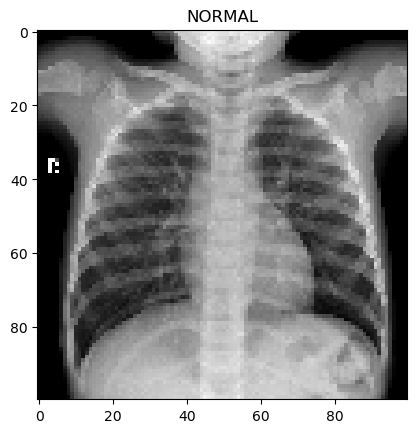

In [248]:
img, img_label, rand_img_num = select_random_image(split_data, classes_data, split_set=0)
show_random_image(classes, classes_data, img, rand_img_num, split_set=0)

In [ ]:
print(img.shape)
img = reshape_img(img)
print(img.shape)

learning_rate = 0.01
c1 = conv_layer(in_dim=reshape_img(split_data[0][0]).shape, conv_size=(3,3), kernel_num=2)
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
sig_cp1 = sigmoid_activation_layer()
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=100)
sig_f1 = sigmoid_activation_layer()
f2 = fully_connected_layer(in_dim=(f1.get_out_dim(), 1), out_dim=20)
sig_f2 = sigmoid_activation_layer()
f3 = fully_connected_layer(in_dim=(f2.get_out_dim(), 1), out_dim=2)
sig_f3 = sigmoid_activation_layer()

loss = 0

fw = c1.forward(img)
fw = p1.forward(fw)
print('c in DIM', img.shape)
print('p in DIM', c1.get_out_dim())
fw = sig_cp1.forward(fw)

fw = f1.forward(fw)
print('f1 in DIM', p1.get_out_dim())
fw = sig_f1.forward(fw)

fw = f2.forward(fw)
print('f2 in DIM', (f1.get_out_dim(), 1))
fw = sig_f2.forward(fw)

fw = f3.forward(fw)
print('f3 in DIM', (f2.get_out_dim(), 1))
fw = sig_f3.forward(fw)

fw = np.reshape(fw, (2,1))

loss += bin_cross_entropy(img_label, fw)
grad = bin_cross_entropy_deriv(img_label, fw)

print('fw', fw)
print('loss', loss)
print('grad', grad)

grad = sig_f3.backward(grad, learning_rate)
grad = f3.backward(grad, learning_rate)

grad = sig_f2.backward(grad, learning_rate)
grad = f2.backward(grad, learning_rate)

grad = sig_f1.backward(grad, learning_rate)
grad = f1.backward(grad, learning_rate)

grad = sig_cp1.backward(grad, learning_rate)
grad = p1.backward(grad, learning_rate)
grad = c1.backward(grad, learning_rate)

(100, 100, 1)
(100, 100, 1)
c in DIM (100, 100, 1)
p in DIM (98, 98, 2)
f1 in DIM (33, 33, 2)
f2 in DIM (100, 1)
f3 in DIM (20, 1)
fw [[0.64293436]
 [0.06450207]]
loss 0.25419449023502005
grad [[-0.77768436]
 [ 0.53447472]]


In [38]:
# test them in succession

#img = np.ones((6, 6, 1))

# index = 0
# for k in range(0,img.shape[0]):
#     for h in range(0,img.shape[1]):
#         img[k, h] = index
#         index += 1

print(img.shape)
img = reshape_img(img)
print(img.shape)

learning_rate = 0.01

c1 = conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2)
a1 = relu_activation_layer(in_dim=c1.get_out_dim())
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=10)
sm1 = sigmoid_activation_layer(in_dim=f1.get_out_dim())
print("before cnn")
print(img)
k = c1.forward(img)
print("after conv forward")
print(k)
k = a1.forward(k)
print("after relu activation forward")
print(k)
k = p1.forward(k)
print("after pooling forward")
print(k)
k = f1.forward(k)
print("after fully connected forward")
print(k)
k = sm1.forward(k)
print("after sigmoid activation forward")
print(k)

loss = k - img_label

k = sm1.backward(loss, learning_rate)
print("after sigmoid activation backward")
print(k)
k = f1.backward(k, learning_rate)
print("after fully connected backward")
print(k)
k = p1.backward(k, learning_rate)
print("after pooling backward")
print(k)
k = a1.backward(k)
print("after relu activation backward")
print(k)
k = c1.backward(k, learning_rate)
print("after conv backward")
print(k)

(224, 224, 1)
(224, 224, 1)
in_dim (224, 224, 1)
self.conv_kernels [None, None]
self.biases [[[ 1.13191588e+00  3.37512715e-01]
  [-2.62674672e-01 -7.45721452e-01]
  [ 1.17831786e+00  3.59260148e-01]
  ...
  [ 1.65060645e+00 -7.29256579e-01]
  [-5.42219294e-01  1.25903545e+00]
  [ 4.68599003e-01 -6.59501832e-01]]

 [[ 4.07595570e-01 -1.26186789e+00]
  [ 1.34920384e+00 -1.15801260e-01]
  [ 2.01802512e+00  9.30809757e-01]
  ...
  [-1.47041652e-01  2.18014047e-01]
  [-3.59422257e-01  5.06290572e-01]
  [-1.10819260e+00 -5.49210611e-01]]

 [[ 1.81246602e-01 -1.30614418e+00]
  [ 6.00198900e-01  1.28451634e+00]
  [-3.93465484e-01  2.63113378e-01]
  ...
  [ 6.16572861e-04 -2.09282185e-01]
  [ 1.07426180e+00 -5.44250109e-01]
  [-1.02809395e+00 -1.20501107e+00]]

 ...

 [[-1.48969821e+00  1.01645874e-01]
  [ 5.43033853e-01 -1.94699626e-02]
  [ 2.38330768e+00  4.75680646e-01]
  ...
  [ 9.07897994e-01  3.41121099e-01]
  [ 5.00128302e-01 -7.14481044e-02]
  [-3.10996280e-01 -4.65101584e-01]]

 [[-6.

ValueError: operands could not be broadcast together with shapes (10952,) (10,) 

In [364]:
class CNN:
    '''
    '''
    def __init__(self):
        self.layers = [
            conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2),
            activation_layer(in_dim=conv_layer.get_out_dim()),
            max_pooling_layer(in_dim=conv_layer.get_out_dim(), pooling_size=(3,3)),
            fully_connected_layer(in_dim=max_pooling_layer.get_out_dim(), out_dim=10),
            sigmoid_layer(in_dim=fully_connected_layer.get_out_dim())
        ]
    def forward(self, img):
        for layer in self.layers:
            img = layer.forward(img)
        return img
    
    def backward(self, out, learning_rate):
        for layer in reversed(self.layers):
            out = layer.backward(out, learning_rate)
        return out

### Test single layers

In [219]:
# test conv layer
a = np.zeros((6,6,2))
for w in range(0,a.shape[0], 2):
    for h in range(0,a.shape[1]):
        a[w, h, 0] = 1

for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1], 2):
        a[w, h, 1] = 1

print("input before conv")
print(a[:,:,0])
print(a[:,:,1])
c = conv_layer(in_dim=a.shape, conv_size=(3,3), kernel_num=3)
print("expected out dim")
print(c.get_out_dim())
d = c.forward(a)
print("output conv shape")
print(d.shape)
print("output conv")
print(d[:,:,1])

input before conv
[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]]
expected out dim
(4, 4, 3)
output conv shape
(4, 4, 3)
output conv
[[-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]
 [-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]]


In [12]:
# test pool layer
a = np.zeros((7, 7, 3))
index = 0
for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1]):
        a[w,h,:] = index
        index += 1
print("input before pool")
print(a[:,:,0])
c = max_pooling_layer(in_dim=a.shape, pooling_size=(3,3))
d = c.forward(a)
print("output pool")
print(d[:,:,0])

input before pool
[[ 0.  1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12. 13.]
 [14. 15. 16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25. 26. 27.]
 [28. 29. 30. 31. 32. 33. 34.]
 [35. 36. 37. 38. 39. 40. 41.]
 [42. 43. 44. 45. 46. 47. 48.]]
output pool
[[16. 19. 20.]
 [37. 40. 41.]
 [44. 47. 48.]]


In [14]:
# test activation layer
a = np.zeros((2, 3, 3))
index = -4
for k in range(0,a.shape[1]):
    for h in range(0,a.shape[2]):
        a[:, k, h] = index
        index += 1
print("input before activation")
print(a)
r = activation_layer(a.shape)
b = r.forward(a)
print(b)

input before activation
[[[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]

 [[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]]
[[[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]

 [[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]]


In [16]:
# test fully connected layer
a = np.ones((2, 3, 3))

print("input before fully connected")
print(a)
c = fully_connected_layer(in_dim=a.shape, out_dim=3)
d = c.forward(a)
print("output pool")
print(d)

input before fully connected
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
output pool
[18. 18. 18.]
